In [107]:
import numpy as np

rng = np.random.default_rng(0)

In [108]:
''' Возьмем простые данные - n-мерное изотропное нормальное распределение N(0, I_d) '''

def logp(x):
    return -0.5 * np.dot(x, x)

def grad_logp(x):
    return -x

''' Здесь придумайте какой-нибудь свой пример с данными по аналогии с гауссинками и проверьте алгоритмы на них '''
def logp_mixt(x):
    mu1 = np.array([-3] * len(x))
    mu2 = np.array([+3] * len(x))

    log_prob1 = -0.5 * np.sum((x - mu1)**2)
    log_prob2 = -0.5 * np.sum((x - mu2)**2)

    max_log = max(log_prob1, log_prob2)
    return max_log + np.log(0.5 * np.exp(log_prob1 - max_log) + 0.5 * np.exp(log_prob2 - max_log))

def grad_logp_mixt(x):
    mu1 = np.array([-3] * len(x))
    mu2 = np.array([+3] * len(x))
    
    log_prob1 = -0.5 * np.sum((x - mu1)**2)
    log_prob2 = -0.5 * np.sum((x - mu2)**2)
    
    max_log = max(log_prob1, log_prob2)
    w1 = 0.5 * np.exp(log_prob1 - max_log)
    w2 = 0.5 * np.exp(log_prob2 - max_log)
    norm = w1 + w2
    w1 /= norm
    w2 /= norm
    
    grad1 = -(x - mu1)
    grad2 = -(x - mu2)
    
    return w1 * grad1 + w2 * grad2

In [109]:
''' Посчитаем ESS через интегрированную автокорреляции '''

def ess(x):
    x = x - x.mean()

    acf = np.correlate(x, x, mode='full')
    acf = acf[len(acf) // 2:]
    acf /= acf[0]

    tau = 1 + 2 * np.sum(acf[1:200])

    return len(x) / tau

In [110]:
''' Базовая реализация MH алгоритма '''

def mh(x0, steps, scale, logp):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        prop = x + rng.normal(0, scale, size=d)

        if np.log(rng.uniform()) < (logp(prop) - logp(x)):
            x = prop; accept += 1

        chain[t] = x

    return chain, accept / steps

In [111]:
# Тут нужно заимплементить Metropolis Adjusted Langevin Algorithm (MALA)

def mala(x0, steps, step,  logp, grad_logp):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        grad_x = grad_logp(x)
        prop = x + (step / 2) * grad_x + np.sqrt(step) * rng.normal(0, 1, size=d)
        grad_prop = grad_logp(prop)
        mean_backward = prop + (step / 2) * grad_prop
        log_q_backward = -0.5 / step * np.sum((x - mean_backward)**2)
        mean_forward = x + (step / 2) * grad_x
        log_q_forward = -0.5 / step * np.sum((prop - mean_forward)**2)
        log_alpha = (logp(prop) - logp(x)) + (log_q_backward - log_q_forward)
        if np.log(rng.uniform()) < log_alpha:
            x = prop
            accept += 1
        chain[t] = x

    return chain, accept / steps

In [112]:
d = 10
steps = 30000
burn = 5000
x0 = np.ones(d) * 3 # стартанев в точке 3 например

mala_step = 0.3 # тут попробуйте подобрать хороший шаг
mh_scale = 2.0 # тут попробуйте подобрать скейл для пропозала в MH. Может какие-то варианты будут лучше MALA?

mh_chain, mh_acc = mh(x0, steps, scale=mh_scale, logp=logp)
mala_chain, mala_acc = mala(x0, steps, step=mala_step, logp=logp, grad_logp=grad_logp)

# Выведите снизу acceptance rate и медианный ESS по размерности d для MH и MALA. Не забудьте обрезать burn-in!

mh_chain_burned = mh_chain[burn:]
mala_chain_burned = mala_chain[burn:]

mh_median_ess = np.median([ess(mh_chain_burned[:, i]) for i in range(d)])
mala_median_ess = np.median([ess(mala_chain_burned[:, i]) for i in range(d)])

print(f"\n{'Метод'} {'Acceptance Rate'} {'Median ESS'}")
print(f"{'MH'} {mh_acc} {mh_median_ess}")
print(f"{'MALA'} {mala_acc} {mala_median_ess}")
print(f"\nУлучшение ESS (MALA vs MH): {mala_median_ess / mh_median_ess}x")


Метод Acceptance Rate Median ESS
MH 0.012 138.02064622944437
MALA 0.9466 2024.080275008141

Улучшение ESS (MALA vs MH): 14.665054325592179x


In [113]:
d = 10
steps = 30000
burn = 5000
x0 = np.ones(d) * 0

mala_step_mix = 0.3
mh_scale_mix = 2.5

mh_chain_2, mh_acc_2 = mh(x0, steps, scale=mh_scale_mix, logp=logp_mixt)

mala_chain_2, mala_acc_2 = mala(x0, steps, step=mala_step_mix, logp=logp_mixt, grad_logp=grad_logp_mixt)

mh_chain_2_burned = mh_chain_2[burn:]
mala_chain_2_burned = mala_chain_2[burn:]

mh_ess_2 = [ess(mh_chain_2_burned[:, i]) for i in range(d)]
mala_ess_2 = [ess(mala_chain_2_burned[:, i]) for i in range(d)]

mh_median_ess_2 = np.median(mh_ess_2)
mala_median_ess_2 = np.median(mala_ess_2)

print(f"\n{'Метод'} {'Acceptance Rate'} {'Median ESS'}")
print("-" * 45)
print(f"{'MH'} {mh_acc_2} {mh_median_ess_2}")
print(f"{'MALA'} {mala_acc_2} {mala_median_ess_2}")
print(f"\nУлучшение ESS (MALA vs MH): {mala_median_ess_2 / mh_median_ess_2}x")


Метод Acceptance Rate Median ESS
---------------------------------------------
MH 0.003033333333333333 81.04648211082491
MALA 0.948 2213.950480140115

Улучшение ESS (MALA vs MH): 27.31704600222753x


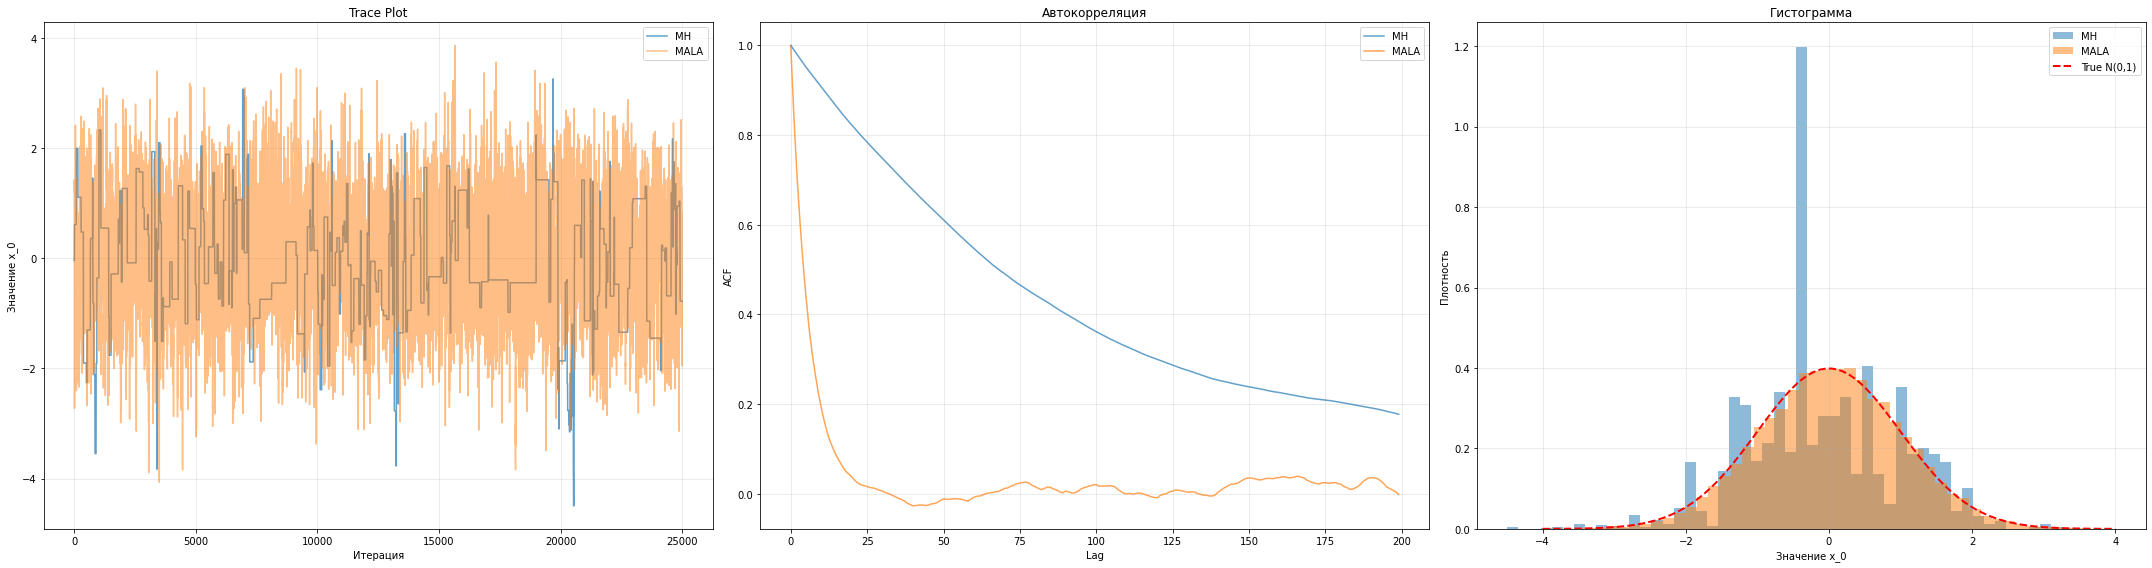

In [114]:
# Здесь нарисуйте 3 графика: trace plot (значение цепи vs итерация),
# график автокорреляции (значение ACF vs задержка по времени) и гистограмма семплов (возьмите какую-то одну размерность)

import matplotlib.pyplot as plt

def compute_acf(x, max_lag=200):
    x = x - x.mean()
    acf = np.correlate(x, x, mode='full')
    acf = acf[len(acf) // 2:]
    acf /= acf[0]
    return acf[:max_lag]

dim_to_plot = 0

mh_trace = mh_chain_burned[:, dim_to_plot]
mala_trace = mala_chain_burned[:, dim_to_plot]

mh_acf = compute_acf(mh_trace)
mala_acf = compute_acf(mala_trace)

fig, axes = plt.subplots(1, 3, figsize=(30, 8))

# trace plot
axes[0].plot(mh_trace, label='MH', alpha=0.7)
axes[0].plot(mala_trace, label='MALA', alpha=0.5)
axes[0].set_xlabel('Итерация')
axes[0].set_ylabel('Значение x_0')
axes[0].set_title('Trace Plot')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Автокорреляция
axes[1].plot(mh_acf, label='MH', alpha=0.7)
axes[1].plot(mala_acf, label='MALA', alpha=0.7)
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('ACF')
axes[1].set_title('Автокорреляция')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].hist(mh_trace, bins=50, alpha=0.5, label='MH', density=True)
axes[2].hist(mala_trace, bins=50, alpha=0.5, label='MALA', density=True)
x_range = np.linspace(-4, 4, 100)
true_density = (1/np.sqrt(2*np.pi)) * np.exp(-0.5*x_range**2)
axes[2].plot(x_range, true_density, 'r', linestyle="--", linewidth=2, label='True N(0,1)')
axes[2].set_xlabel('Значение x_0')
axes[2].set_ylabel('Плотность')
axes[2].set_title('Гистограмма')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


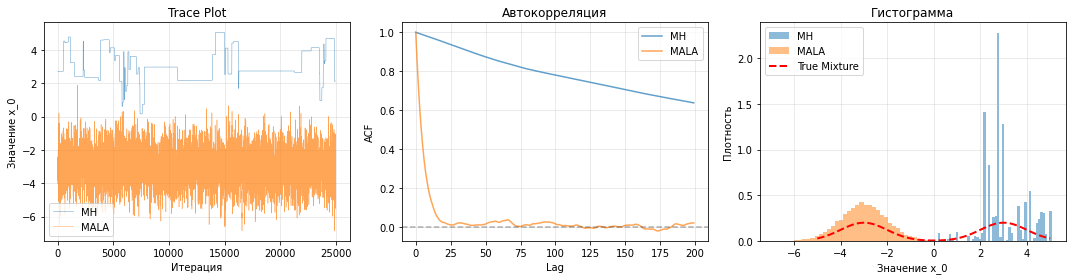

In [115]:
dim_to_plot = 0

mh_trace_2 = mh_chain_2_burned[:, dim_to_plot]
mala_trace_2 = mala_chain_2_burned[:, dim_to_plot]

mh_acf_2 = compute_acf(mh_trace_2)
mala_acf_2 = compute_acf(mala_trace_2)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# trace plot
axes[0].plot(mh_trace_2, label='MH', alpha=0.7, linewidth=0.5)
axes[0].plot(mala_trace_2, label='MALA', alpha=0.7, linewidth=0.5)
axes[0].set_xlabel('Итерация')
axes[0].set_ylabel('Значение x_0')
axes[0].set_title('Trace Plot')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Автокореляция
axes[1].plot(mh_acf_2, label='MH', alpha=0.7)
axes[1].plot(mala_acf_2, label='MALA', alpha=0.7)
axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('ACF')
axes[1].set_title('Автокорреляция')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Гистограмма
axes[2].hist(mh_trace_2, bins=50, alpha=0.5, label='MH', density=True)
axes[2].hist(mala_trace_2, bins=50, alpha=0.5, label='MALA', density=True)
x_range = np.linspace(-5, 5, 100)
mu1 = -3
mu2 = 3
true_density = 0.5 * (1/np.sqrt(2*np.pi)) * np.exp(-0.5*(x_range - mu1)**2) + 0.5 * (1/np.sqrt(2*np.pi)) * np.exp(-0.5*(x_range - mu2)**2)
axes[2].plot(x_range, true_density, 'r--', linewidth=2, label='True Mixture')
axes[2].set_xlabel('Значение x_0')
axes[2].set_ylabel('Плотность')
axes[2].set_title('Гистограмма')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [116]:
# Вывод
# MALA показывает значительно лучшие результаты по сравнению с MH в плане ESS и качества аппроксимации целевого распределения, так как MALA
# использует информацию о направлении градиента.
#
# P.S. В последний момент понял, что забыл со своими данными эксперимент сделать, поэтому потом сразу исправил :/